# Parallel Computing
---

This notebooks explores parallel computing in Julia programming language.([JuliaOulu20](https://github.com/carstenbauer/JuliaOulu20/blob/master/Day3/1_parallel_computing.ipynb))

## Libraries

In [1]:
using Hwloc
using Plots, LaTeXStrings
using BenchmarkTools

## Know you hardware specs: how many CPU core?

In [2]:
Hwloc.num_physical_cores()

4

In [3]:
# linux
run(`lscpu`) 

# macOS
# run(pipeline(`sysctl -a`, `grep machdep.cpu`))

# windows
# run(`wmic cpu get NumberOfCores,NumberOfLogicalProcessors`)

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          4
On-line CPU(s) list:             0-3
Thread(s) per core:              1
Core(s) per socket:              4
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           62
Model name:                      Intel(R) Xeon(R) CPU E5-2603 v2 @ 1.80GHz
Stepping:                        4
CPU MHz:                         1383.283
CPU max MHz:                     1800.0000
CPU min MHz:                     1200.0000
BogoMIPS:                        3591.39
Virtualization:                  VT-x
L1d cache:                       128 KiB
L1i cache:                       128 KiB
L2 cache:                        1 MiB
L3 cache:                      

## Speed up expectation: Amdhal's law

>"the overall performance improvement gained by optimizing a single part of a system is limited by the fraction of time that the improved part is actually used"   

Reddy, Martin (2011). API Design for C++. Burlington, Massachusetts: Morgan Kaufmann Publishers. doi:10.1016/C2010-0-65832-9

Maximal Theoritical speedup by parallelizing: 

$$S(p, n) = \frac{n}{n(1-p)+p}$$ 
where 
- $S$ is the theoritical speed up of the execution of th ewhole task.
- $p$ is the proportion of execution time that benefits from improved resources.
- $n$ is the speedup of the part of the task that benefits from improved resources.

In addition we have:
$$S(p, n)\leq \frac{1}{1-p} \quad  and  \quad \lim_{n\to\infty}S(p, n) = \frac{1}{1-p}$$

In [4]:
S(p,n) = n/(n*(1 - p) + p)

S (generic function with 1 method)

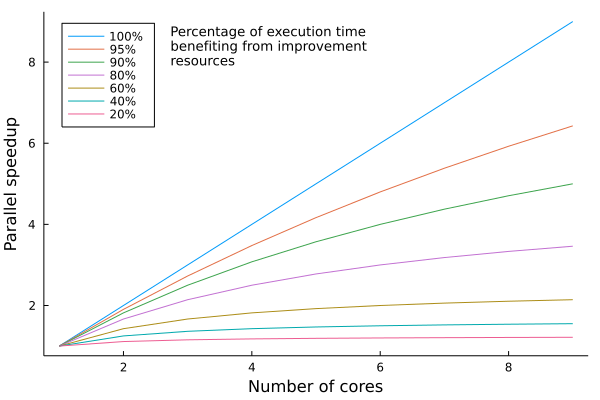

In [5]:
pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> S(p,n), 1:9, 
        lw=1,
        label="$(Int(p*100))%", 
        legend=:topleft, 
        xlab="Number of cores", ylab="Parallel speedup",
        grid = false, 
    )
end
pl
annotate!(2.75, 8.4, text("Percentage of execution time\nbenefiting from improvement\nresources", :black, :left, 9))

## Parallel Computing types

There are many types of parallelism in Julia:

|Parallelism types                                         | Julia features                                      |
| -------------------------------------------------------- | --------------------------------------------------- |
| Instruction level parallelism                            | `@simd`                                             | 
| Multi-threading (process shared memory)                  | `Base.Threads.@threads`                             |
| Tasks (Coroutines) (scheduling Tasks on several threads) | `@async`, `@sync` `wait`, `fetch`, `Channel`      |
| Multi-Core processing (maybe system shared memory)       | `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`|
| Distributed processing (involving multiple machines)     | `@spawnat`, `@fetch`, `RemoteChannel`, `DArray`     |

## Tasks (coroutines)

>"Tasks are a control flow feature that allows computations to be suspended and resumed in a flexible manner."   
    
(Julia documentation)

### To create a task

In [6]:
f_sum() = sum(i for i in 1:1000); # NO ARGUMENTS !!!!

In [7]:
# create a task
t = Task(f_sum);

In [8]:
schedule(t)

Task (done) @0x00007ff2466dfde0

Alternatively, we can use the macro `@task`:

In [9]:
t_2 = @task begin
    sum(i for i in 1:1000)
end;

In [10]:
istaskdone(t)

true

In [11]:
istaskstarted(t_2)

false

In [12]:
schedule(t_2)

Task (done) @0x00007ff247422e10

In [13]:
istaskdone(t_2)

true

### Asynchronous Programming

To create a task and schedule it right away, we can use `@async x` equivalent to `schedule(@task x)`:

In [14]:
@async f_sum

Task (done) @0x00007ff249688460

In the next example, the script of the command line, `@time` macro, fully proceeds without waiting for the task,  sleeping for 2 seconds, to complete.

In [15]:
@time @async sleep(2)

  0.013713 seconds (303 allocations: 15.633 KiB)


Task (runnable) @0x00007ff2496885d0

In the opposite, we can use the macro `@sync` to synchronize and wait for all encapsulated tasks:

In [16]:
@time @sync @async sleep(2)

  2.044828 seconds (799 allocations: 46.845 KiB, 2.12% compilation time)


Task (done) @0x00007ff2495382f0

For example, we can specify the order of the task:

In [17]:
@sync begin
    @async (sleep(2); println("And I come third."))
    @async println("Hi , I am first!")
    @async (sleep(1); println("I come second."))    
end;

Hi , I am first!
I come second.
And I come third.


## Distributed processing

Distributed computing in Julia means having multiple separate Julia instances running on different cores on the same or different machines.

The package `Distributed` loads all the tools necessary for distributed computing.

In [4]:
using Distributed

### Multi-core

By default, Julia start with one process on one core. One main process manages (coordinates) all the worker processes performing the actual computations.

In [19]:
# number of available processes
nprocs()

1

To increase number workers (Julia processes), we use the macro `addproc`:

In [20]:
# we add 3 worker processes
addprocs(3)

3-element Vector{Int64}:
 2
 3
 4

In [21]:
nworkers()

3

In [22]:
# nprocs includes the main worker
nprocs()

4

We can get the workers process id (pid) from the function `workers()`:

In [23]:
workers()

3-element Vector{Int64}:
 2
 3
 4

To remove the processes we use:

In [24]:
rmprocs(workers())

Task (done) @0x00007ff245a6ae10

In [25]:
nprocs()

1

Let add more workers:

In [7]:
addprocs(3)

3-element Vector{Int64}:
 2
 3
 4

> One ring to rule them all!

To start tasks/computations on workers, we can use the following macros:
- `@spawn`: runs a command or a code block on any worker and returns a `Future` to it's result.(a kind of `@async` for remote processes)
- `@spawnat`: same as @spawn but we can specify which worker by providing its pid.

#### Example `@spawn`

Generate a random matrix on one of the workers:

In [27]:
@spawn rand(3,3)

Future(5, 1, 8, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 140679624790272, 0)), nothing)

In [28]:
m = @spawn rand(3,3)

Future(6, 1, 9, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (140679607283248, 140679607283248, 0)), nothing)

In [29]:
fetch(m)

3×3 Matrix{Float64}:
 0.578908  0.983585  0.919587
 0.813208  0.306615  0.405615
 0.800001  0.769207  0.0463157

#### Example @fetch

Instead, we can use the macro `@fetch` that combines `@spawn` and `fetch()`:

In [30]:
@fetch rand(3, 3)

3×3 Matrix{Float64}:
 0.526897  0.72916   0.82206
 0.336998  0.246329  0.65366
 0.112133  0.502214  0.384519

To know which work did the work, we can use the function `myid()`:

In [31]:
@fetch begin
    println(myid())
    rand(3,3)
end

      From worker 5:	5


3×3 Matrix{Float64}:
 0.504872  0.172121  0.684127
 0.560469  0.354485  0.667174
 0.317341  0.764278  0.283704

#### Example @fetchfrom

Using `@spawnat` and `@fetchfrom` we can assign the work to a specific worker:

In [32]:
@fetchfrom 7 begin
    println(myid())
    rand(3,3)
end

      From worker 7:	7


3×3 Matrix{Float64}:
 0.172175  0.537102  0.888316
 0.506388  0.478871  0.158479
 0.677964  0.380986  0.748961

We can use `@sync` to wait for all workers to complete their tasks:

In [33]:
@sync begin
    pids = workers()
    @spawnat pids[1] (sleep(2); println("And I come third."))
    @spawnat pids[2] println("Hi , I am first!")
    @spawnat pids[3] (sleep(1); println("I come second."))
end;
println("Done!")

      From worker 6:	Hi , I am first!
      From worker 7:	I come second.
      From worker 5:	And I come third.
Done!


#### Example @everywhere

We need to think of every worker as a separate Julia instance. Therefore, we use the macro `@everywhere` to excute a block on all workers:

In [8]:
@everywhere begin 
    using Random
    
    function complex_calculation()
        println(myid())
        sleep(1)
        randexp(5) 
    end
end

In [12]:
@time @fetch complex_calculation()

      From worker 2:	2
  2.981441 seconds (2.60 k allocations: 165.766 KiB, 0.02% compilation time)


5-element Vector{Float64}:
 0.366361770658632
 1.1746688514005508
 2.948945604966128
 0.13834728024781637
 0.9069627501524343

In [13]:
@time begin
        sleep(1)
    randexp(5)
    end

  1.000976 seconds (37 allocations: 1.156 KiB)


5-element Vector{Float64}:
 0.30992270573578923
 1.5445742273293526
 0.45757630729340526
 0.1826957902412693
 0.046034376344930614

### Data movement

> Reducing the number of messages and the amount of data sent is critical to achieving performance and scalability. 

(Julia documentation)

Let understand the difference between the two following methods:

In [37]:
function method_1()
    A = rand(100,100)
    B = rand(100,100)
    C = @fetch A^2 * B^2
end

method_1 (generic function with 1 method)

In the method 1:
- A and B are created on the main process
- A and B are transferred to a worker
- A and B are squared and multiplied on the worker process 
- the result is finally transferred back to the main process

In [38]:
function method_2()
    C = @fetch rand(100,100)^2 * rand(100,100)^2
end

method_2 (generic function with 1 method)

In the method 2, the same worker:
- creates random matrices
- squares them
- multiples them
- the result is finally transferred back to the main process

In [39]:
@btime method_1();
@btime method_2();

  1.128 ms (88 allocations: 237.76 KiB)
  931.930 μs (66 allocations: 80.91 KiB)


Method 2 is faster, since we save the allocation of A, B and the transfer from main to the worker.

#### Avoid Global 

In [40]:
myglobal = 4

4

In [41]:
function whohas(s::String)
    @everywhere begin
        var = Symbol($s)
        if isdefined(Main, var)
            println("$var exists.")
        else
            println("Doesn't exist.")
        end
    end
    nothing
end

whohas (generic function with 1 method)

In [42]:
whohas("myglobal")

      From worker 5:	Doesn't exist.
      From worker 6:	Doesn't exist.
myglobal exists.
      From worker 7:	Doesn't exist.


In [43]:
@fetchfrom 6 myglobal+2

6

In [44]:
whohas("myglobal")

myglobal exists.
      From worker 5:	Doesn't exist.
      From worker 6:	myglobal exists.
      From worker 7:	Doesn't exist.


### Explicit Data movement

Channels are used in Julia to explicitly move data between workers. The follwing methods are useful for exchanging data between workers: `put!`, `take!`, `fetch`, `isready` and `wait`.

#### Example Channel

In [45]:
# construct a channel that can hold up to 5 integers
ch = Channel{Int}(5)

Channel{Int64}(5) (empty)

In [46]:
isready(ch)

false

In [47]:
put!(ch, 3)

3

In [48]:
isready(ch)

true

In [49]:
take!(ch)

3

In [50]:
put!(ch, 4)

4

In [51]:
# take without removing from the channel
fetch(ch)

4

In [52]:
take!(ch)

4

In [53]:
isready(ch)

false

DO NOT take!(ch) if the channel is empty, the Julia session will hang.

#### Example RemoteChannel

A `Channel` is local to a process. Worker X cannot directly refer to a `Channel` on worker Y and vice-versa. A `RemoteChannel`, however, can put and take values across workers.

In [54]:
nworkers()

3

In [55]:
# creates a channel on the second worker process
# create a RemoteChannel handle to this channel on the main process
const mychannel = RemoteChannel(()->Channel{Int}(10), workers()[2])

RemoteChannel{Channel{Int64}}(6, 1, 13248)

In [56]:
whohas("mychannel")

mychannel exists.
      From worker 5:	Doesn't exist.
      From worker 6:	Doesn't exist.
      From worker 7:	Doesn't exist.


In [57]:
function do_something()
    rc = RemoteChannel(()->Channel{Int}(10)) # on the main process
    @sync for p in workers()
        @spawnat p put!(rc, myid())
    end
    rc
end

r = do_something()

RemoteChannel{Channel{Int64}}(1, 1, 13256)

In [58]:
isready(r)

true

In [59]:
while isready(r)
    @show take!(r)
end

take!(r) = 6
take!(r) = 5
take!(r) = 7


## Parallel computing: `@distributed` and `pmap`

### Parallel loops: `@distributed`

In [177]:
using Distributed, BenchmarkTools
rmprocs(workers()); 
addprocs(4); 
nworkers()

4

Let's implement a simple example to demonstrate how `@distributed` works. We simulate the result of flipping a coin and add the number of times we get a head over a loop.

#### Serial implementaion 

In [65]:
# simulate flipping coin and count heads (true)
function add_head_serial(n)
    c = 0
    for i in 1:n
        c += rand(Bool)
    end
    
    return c
end

add_head_serial (generic function with 1 method)

In [91]:
btiming = @benchmark add_head_serial(200_000_000);
t_serial = minimum(btiming).time*10^-6 # ms

547.320704

#### Distributed implementaion 

In [67]:
?@distributed

```
@distributed
```

A distributed memory, parallel for loop of the form :

```
@distributed [reducer] for var = range
    body
end
```

The specified range is partitioned and locally executed across all workers. In case an optional reducer function is specified, `@distributed` performs local reductions on each worker with a final reduction on the calling process.

Note that without a reducer function, `@distributed` executes asynchronously, i.e. it spawns independent tasks on all available workers and returns immediately without waiting for completion. To wait for completion, prefix the call with [`@sync`](@ref), like :

```
@sync @distributed for var = range
    body
end
```


In [75]:
# simulate flipping coin and count heads (true)
function add_head_distributed(n)
    c = @distributed (+) for i in 1:n
        (rand(Bool))
    end
    
    return c
end

add_head_distributed (generic function with 1 method)

In [92]:
btiming = @benchmark add_head_distributed(200_000_000);
t_distributed = minimum(btiming).time*10^-6 # ms

169.37930599999999

By using distributed, we speed up the function ~3.3 times:

In [94]:
speedup = t_serial/t_distributed

3.231331600803702

We can display how the work is distributed among our worker:

In [97]:
# verbose distributed version
function add_head_distributed_verbose(n)
    c = @distributed (+) for i in 1:n
        x = rand(Bool)
        println(x);
        x
    end
    c
end


add_head_distributed_verbose (generic function with 1 method)

In [98]:
add_head_distributed_verbose(8)

      From worker 8:	false
      From worker 8:	false
      From worker 10:	false
      From worker 10:	true
      From worker 9:	false
      From worker 9:	false
      From worker 11:	true
      From worker 11:	true


3

#### `@distributed` Common mistake

Be aware of what happens by making our variable global:

In [104]:
function test_distributed(n)
    c = 0
    @distributed (+) for i in 1:n
        c += 1
    end
    return c
end;

In [105]:
test_distributed(10)

0

Let see what is going on for every worker:

In [110]:
c = 0
@distributed (+) for i in 1:10
    println("1")
    global c += 1
end;

      From worker 10:	1
      From worker 10:	1
      From worker 9:	1
      From worker 9:	1
      From worker 9:	1
      From worker 11:	1
      From worker 11:	1
      From worker 8:	1
      From worker 8:	1
      From worker 8:	1


In [111]:
c

0

In [109]:
@everywhere @show c

c = 0
      From worker 11:	c = 2
      From worker 9:	c = 3
      From worker 8:	c = 3
      From worker 10:	c = 2


The variable `c` was copied as reference in the distributed loop. Every worker processed its own copy of `c`, but the result, i.e. the incremented value, was not saved and the reference is returned to the main process where the values has not changed.


In [113]:
c = @distributed (+) for i in 1:10
    c = 1
    println("1")
    c
end

      From worker 8:	1
      From worker 8:	1
      From worker 9:	1
      From worker 9:	1
      From worker 9:	1
      From worker 8:	1
      From worker 10:	1
      From worker 10:	1
      From worker 11:	1
      From worker 11:	1


10

In [123]:
c = zeros(10)
@distributed for i = 1:10
    c[i] = i
end

Task (runnable) @0x00007ff24666c010

Without reduction function, `@distributed` returns a `Task`, simlar to distributing `@spawn` for all the iterations.

In [124]:
c

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [125]:
@everywhere @show c

c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 8:	c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.0]
      From worker 9:	c = [1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 10:	c = [0.0, 0.0, 0.0, 4.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0]
      From worker 11:	c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0]


### `SharedArray`

We can use a `SharedArray` to actually make all processes operate on the same array. It needs to be loaded everywhere:

In [14]:
@everywhere using SharedArrays

In [133]:
?SharedArray

search: SharedArray SharedArrays SharedMatrix



```
SharedArray{T}(dims::NTuple; init=false, pids=Int[])
SharedArray{T,N}(...)
```

Construct a `SharedArray` of a bits type `T` and size `dims` across the processes specified by `pids` - all of which have to be on the same host.  If `N` is specified by calling `SharedArray{T,N}(dims)`, then `N` must match the length of `dims`.

If `pids` is left unspecified, the shared array will be mapped across all processes on the current host, including the master. But, `localindices` and `indexpids` will only refer to worker processes. This facilitates work distribution code to use workers for actual computation with the master process acting as a driver.

If an `init` function of the type `initfn(S::SharedArray)` is specified, it is called on all the participating workers.

The shared array is valid as long as a reference to the `SharedArray` object exists on the node which created the mapping.

```
SharedArray{T}(filename::AbstractString, dims::NTuple, [offset=0]; mode=nothing, init=false, pids=Int[])
SharedArray{T,N}(...)
```

Construct a `SharedArray` backed by the file `filename`, with element type `T` (must be a bits type) and size `dims`, across the processes specified by `pids` - all of which have to be on the same host. This file is mmapped into the host memory, with the following consequences:

  * The array data must be represented in binary format (e.g., an ASCII format like CSV cannot be supported)
  * Any changes you make to the array values (e.g., `A[3] = 0`) will also change the values on disk

If `pids` is left unspecified, the shared array will be mapped across all processes on the current host, including the master. But, `localindices` and `indexpids` will only refer to worker processes. This facilitates work distribution code to use workers for actual computation with the master process acting as a driver.

`mode` must be one of `"r"`, `"r+"`, `"w+"`, or `"a+"`, and defaults to `"r+"` if the file specified by `filename` already exists, or `"w+"` if not. If an `init` function of the type `initfn(S::SharedArray)` is specified, it is called on all the participating workers. You cannot specify an `init` function if the file is not writable.

`offset` allows you to skip the specified number of bytes at the beginning of the file.


In [134]:
A = rand(3,3)

3×3 Matrix{Float64}:
 0.801309  0.708869  0.405519
 0.830366  0.381183  0.986458
 0.117643  0.761489  0.177377

In [137]:
A_shared = SharedArray(A)

3×3 SharedMatrix{Float64}:
 0.801309  0.708869  0.405519
 0.830366  0.381183  0.986458
 0.117643  0.761489  0.177377

Let's create a function that will generate a Shared Array and fill it over a distributed loop:

In [15]:
function fill_shared(N)
    S = SharedMatrix{Float64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared (generic function with 1 method)

If we repeat the method `fill_shared_1()` with various N, we will observe that the array is not always completely filled. The array may still contain 0 values.

In [26]:
@time fill_shared(5)

  0.001825 seconds (288 allocations: 12.586 KiB)


5×5 SharedMatrix{Float64}:
 1.0   6.0  11.0  16.0  21.0
 2.0   7.0  12.0  17.0  22.0
 3.0   8.0  13.0  18.0  23.0
 4.0   9.0  14.0  19.0  24.0
 5.0  10.0  15.0  20.0  25.0

We need to use @sync to synchronize our distributed for loop.

In [24]:
function fill_shared_sync(N)
    S = SharedMatrix{Float64}(N,N)
   @sync @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared_sync (generic function with 1 method)

In [25]:
@time fill_shared_sync(5)

  0.109612 seconds (60.87 k allocations: 2.928 MiB, 45.67% compilation time)


5×5 SharedMatrix{Float64}:
 1.0   6.0  11.0  16.0  21.0
 2.0   7.0  12.0  17.0  22.0
 3.0   8.0  13.0  18.0  23.0
 4.0   9.0  14.0  19.0  24.0
 5.0  10.0  15.0  20.0  25.0

Let's compare benchmarks:

In [158]:
# regular array
function fill_regular(N)
    A = Matrix{Int64}(undef,N,N)
    for i in 1:length(A)
        A[i] = i
    end
    A
end

btiming = @benchmark fill_regular(1_000);
t_regular = minimum(btiming).time*10^-6 # ms

1.19189

In [162]:
@btime fill_regular(1_000)

  1.173 ms (2 allocations: 7.63 MiB)


In [161]:
# shared array
btiming = @benchmark fill_shared_sync(1_000);
t_shared = minimum(btiming).time*10^-6 # ms

7.6289359999999995

In [163]:
@btime fill_shared_sync(1_000);

  7.652 ms (173 allocations: 9.54 KiB)


Here due to the allocations, we increased our time.

### Parallel loops: `pmap`

The `pmap` function, i.e. parallel map function, is very usefull when we want to apply a function to all elements in collection.
For example, let's compute the of a bunch of large matrices in parallel.

In [178]:
@everywhere using LinearAlgebra

In [179]:
M = Matrix{Float64}[rand(1000,1000) for i = 1:10];

In [180]:
pmap(svdvals, M)

10-element Vector{Vector{Float64}}:
 [500.1878598140338, 18.256090074423486, 18.116014306479837, 18.020437800524626, 17.91945993077604, 17.846649270567745, 17.7595210794703, 17.656221988929545, 17.61626644002656, 17.565362101326997  …  0.12972652110192948, 0.11829101691797737, 0.10700798319710886, 0.10485682097128719, 0.0953891478451079, 0.05790870159568728, 0.04276940408526146, 0.033251220491030645, 0.011015186900696434, 0.0026242730925120196]
 [500.26379897989955, 18.110664632929495, 18.024226577524608, 17.919992578429035, 17.84764227771723, 17.804982476086874, 17.791228784208887, 17.72561607831644, 17.641667368140183, 17.59968093744161  …  0.12202493913615586, 0.1152678450677357, 0.10400413345750947, 0.09763257499533612, 0.07124694351070081, 0.058030997381948966, 0.04188428362497294, 0.02782850985673855, 0.023017466359591197, 0.003046501673200027]
 [499.8945369097113, 18.090438462024306, 18.056484681509623, 17.940157189360995, 17.888545807052335, 17.83532128510087, 17.70524791396364

As we did it earlier, we can check which worker participated:

In [181]:
pmap(m->begin println(myid()); svdvals(m) end, M);

      From worker 18:	18
      From worker 19:	19
      From worker 17:	17
      From worker 16:	16
      From worker 18:	18
      From worker 19:	19
      From worker 16:	16
      From worker 17:	17
      From worker 18:	18
      From worker 19:	19


In [182]:
?pmap

search: pmap promote_shape plots_heatmap plots_heatmap! typemax



```
pmap(f, [::AbstractWorkerPool], c...; distributed=true, batch_size=1, on_error=nothing, retry_delays=[], retry_check=nothing) -> collection
```

Transform collection `c` by applying `f` to each element using available workers and tasks.

For multiple collection arguments, apply `f` elementwise.

Note that `f` must be made available to all worker processes; see [Code Availability and Loading Packages](@ref code-availability) for details.

If a worker pool is not specified, all available workers, i.e., the default worker pool is used.

By default, `pmap` distributes the computation over all specified workers. To use only the local process and distribute over tasks, specify `distributed=false`. This is equivalent to using [`asyncmap`](@ref). For example, `pmap(f, c; distributed=false)` is equivalent to `asyncmap(f,c; ntasks=()->nworkers())`

`pmap` can also use a mix of processes and tasks via the `batch_size` argument. For batch sizes greater than 1, the collection is processed in multiple batches, each of length `batch_size` or less. A batch is sent as a single request to a free worker, where a local [`asyncmap`](@ref) processes elements from the batch using multiple concurrent tasks.

Any error stops `pmap` from processing the remainder of the collection. To override this behavior you can specify an error handling function via argument `on_error` which takes in a single argument, i.e., the exception. The function can stop the processing by rethrowing the error, or, to continue, return any value which is then returned inline with the results to the caller.

Consider the following two examples. The first one returns the exception object inline, the second a 0 in place of any exception:

```julia-repl
julia> pmap(x->iseven(x) ? error("foo") : x, 1:4; on_error=identity)
4-element Array{Any,1}:
 1
  ErrorException("foo")
 3
  ErrorException("foo")

julia> pmap(x->iseven(x) ? error("foo") : x, 1:4; on_error=ex->0)
4-element Array{Int64,1}:
 1
 0
 3
 0
```

Errors can also be handled by retrying failed computations. Keyword arguments `retry_delays` and `retry_check` are passed through to [`retry`](@ref) as keyword arguments `delays` and `check` respectively. If batching is specified, and an entire batch fails, all items in the batch are retried.

Note that if both `on_error` and `retry_delays` are specified, the `on_error` hook is called before retrying. If `on_error` does not throw (or rethrow) an exception, the element will not be retried.

Example: On errors, retry `f` on an element a maximum of 3 times without any delay between retries.

```julia
pmap(f, c; retry_delays = zeros(3))
```

Example: Retry `f` only if the exception is not of type [`InexactError`](@ref), with exponentially increasing delays up to 3 times. Return a `NaN` in place for all `InexactError` occurrences.

```julia
pmap(f, c; on_error = e->(isa(e, InexactError) ? NaN : rethrow()), retry_delays = ExponentialBackOff(n = 3))
```


>Julia's pmap is designed for the case where each function call does a large amount of work.
In contrast, @distributed can handle situations where each iteration is tiny, perhaps only summing two numbers.

(Julia documentation)

Let's compare the timing:

In [185]:
function svds_serial_loop(M)
    svds = Vector{Vector{Float64}}(undef, 10)
    for (i, m) in enumerate(M)
        svds[i] = svdvals(m)
    end
    svds
end

svds_serial_loop (generic function with 1 method)

In [188]:
@btime svds_serial_loop(M);

  3.518 s (91 allocations: 82.10 MiB)


In [189]:
@btime svdvals.(M);

  3.484 s (94 allocations: 82.10 MiB)


In [190]:
@btime pmap(svdvals, M);

  2.776 s (630 allocations: 102.67 KiB)


In [27]:
rmprocs(workers())

Task (done) @0x00007fb60762de40